In [1]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import glob
import json
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.stats import percentileofscore, zscore
import pickle
import tables

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [2]:

data_dir = '/media/bigdata/Abuzar_Data/bla_gc/AM35/AM35_4Tastes_201230_115322/'
dat = ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params
# dat.firing_rate_params['type'] = 'baks'
# dat.firing_rate_params['baks_resolution'] = 10e-3

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()

All tastes have equal dimensions,concatenating and normalizing


In [3]:
spike_array = np.array(dat.spikes)
print(spike_array.shape)
print(dat.firing_array.shape)

(4, 30, 33, 7000)
(4, 33, 30, 271)


/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


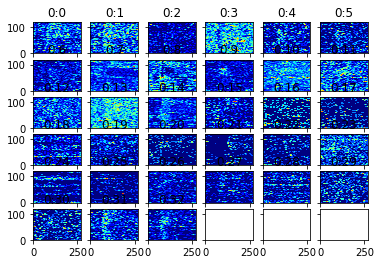

In [4]:
visualize.firing_overview(dat.all_normalized_firing);

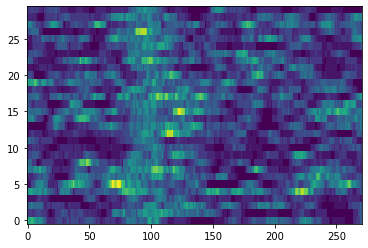

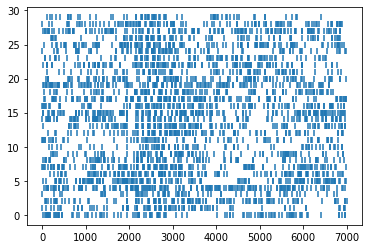

In [191]:
nrn = 14
taste = 0
this_spikes = spike_array[taste,:,nrn]
this_firing = dat.firing_array[taste,nrn]

visualize.imshow(this_firing)
plt.figure()
plt.scatter(*np.where(this_spikes)[::-1],marker = '|')

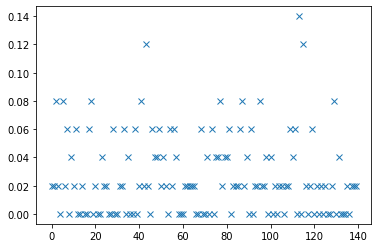

In [189]:
this_trial = this_spikes[4]
bin_size = 50
data_vec = this_trial.reshape((-1,bin_size)).mean(axis=-1)
#data_vec = zscore(data_vec)
#data_vec = this_firing[1][::5]
plt.plot(data_vec, 'x')

## GP Test

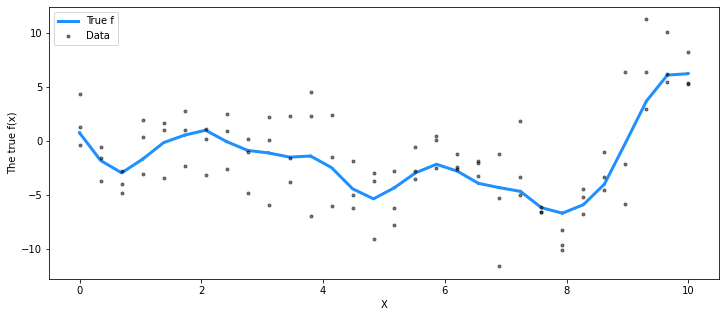

In [2]:
# set the seed
np.random.seed(1)

n_x = 30
n = n_x * 3 # The number of data points
X = np.linspace(0, 10, n_x)[:, None]  # The inputs to the GP, they must be arranged as a column vector
X = np.concatenate([X,np.linspace(0, 10, n_x)[:, None]],axis=0)
X = np.concatenate([X,np.linspace(0, 10, n_x)[:, None]],axis=0)
X = np.sort(X,axis=0)

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 3.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    # Specify the covariance function.
    #cov = (η ** 2) * pm.gp.cov.Matern52(1, ℓ)
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = (η ** 2) * pm.gp.cov.ExpQuad(1, ls=ℓ)
    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov)

    # The scale of the white noise term can be provided,
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

In [4]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X,pred_noise=True)

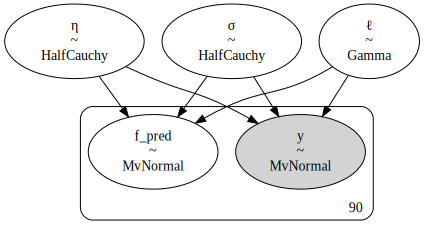

In [5]:
pm.model_to_graphviz(model)

In [6]:
with model:
    #trace = pm.sample(1000)
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=40000, method=inference)
    trace = approx.sample(draws=2000)

Finished [100%]: Average Loss = 246.27


In [7]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=5)

No handles with labels found to put in legend.


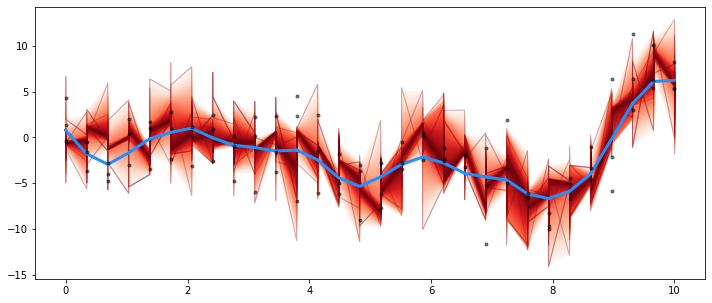

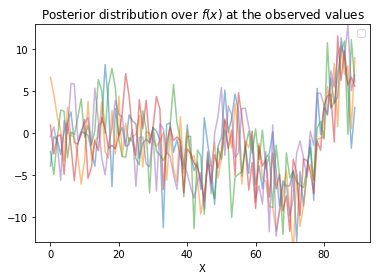

In [8]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.figure()
plt.plot(pred_samples['f_pred'].T, "-", ms=3, alpha=0.5)

# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

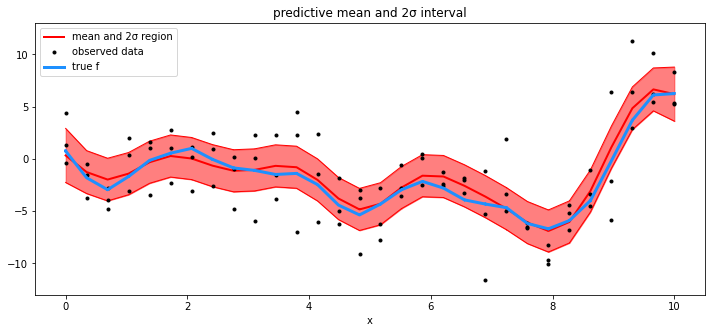

In [9]:
# predict
mu, var = gp.predict(X, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(X, mu + 2 * sd, "r", lw=1)
plt.plot(X, mu - 2 * sd, "r", lw=1)
plt.fill_between(X.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("predictive mean and 2σ interval")
plt.legend();

## Latent firing rate

In [172]:
X = np.arange(len(data_vec))[:, None]
y = data_vec
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    # Specify the covariance function.
    #cov = (η ** 2) * pm.gp.cov.Matern52(1, ℓ)
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = (η ** 2) * pm.gp.cov.ExpQuad(1, ls=ℓ)
    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov)

    # The scale of the white noise term can be provided,
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)
    #mp = pm.find_MAP()

In [173]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X,pred_noise=True)

In [192]:
with model:
    #trace = pm.sample(1000)
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=40000, method=inference)
    trace = approx.sample(draws=2000)

Finished [100%]: Average Loss = 372.99


In [79]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=5)

No handles with labels found to put in legend.


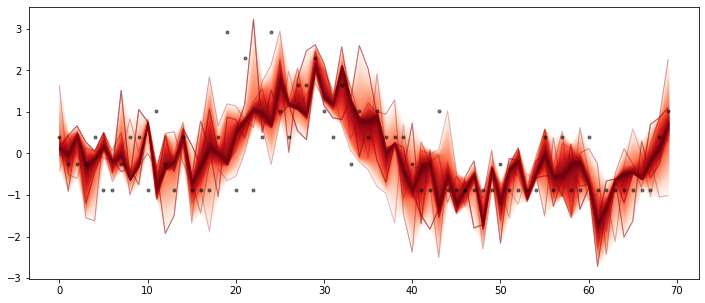

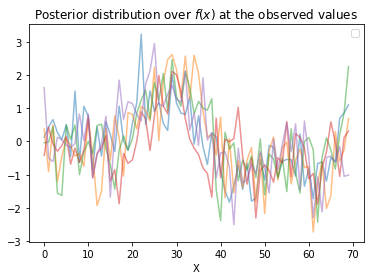

In [80]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X)

# plot the data and the true latent function
#plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.figure()
plt.plot(pred_samples['f_pred'].T, "-", ms=3, alpha=0.5)

# axis labels and title
plt.xlabel("X")
#plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [ ]:
# predict
mu, var = gp.predict(X, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(X, mu + 2 * sd, "r", lw=1)
plt.plot(X, mu - 2 * sd, "r", lw=1)
plt.fill_between(X.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
#plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
#plt.ylim([-13, 13])
plt.title("predictive mean and 2σ interval")
plt.legend();

## GP Latent Model

Text(0.5, 1.0, 'Binned Spikes')

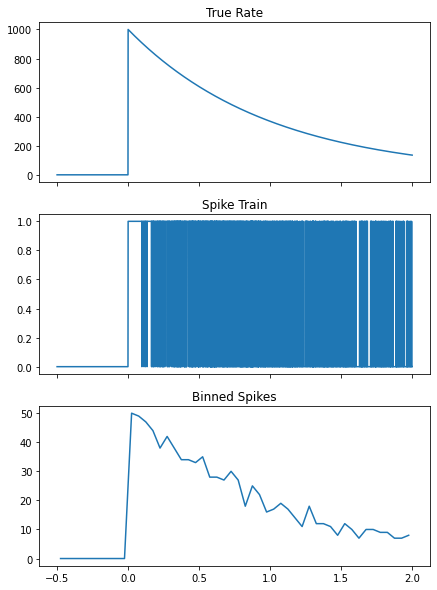

In [60]:
## Quick change at stim delivery
dt = 0.001
x = np.arange(-0.5, 2, step = dt)
y = np.exp(-x*1)*1000
y[x<=0] = 0

# y = y[x>0]
# x = x[x>0]

spikes = np.random.uniform(size = len(y)) < y*dt
bin_width = 50
binned_counts = spikes.reshape((-1, bin_width)).sum(axis=-1)
binned_x = x.reshape((-1, bin_width)).mean(axis=-1)
fig,ax = plt.subplots(3,1, figsize=(7,10), sharex=True)
ax[0].plot(x,y)
ax[0].set_title('True Rate')
ax[1].plot(x,spikes)
ax[1].set_title('Spike Train')
ax[2].plot(binned_x, binned_counts)
ax[2].set_title('Binned Spikes')

In [61]:
# binned_x = np.arange(len(data_vec))
# X=binned_x.copy()[:,None]
# binned_counts = data_vec + 1
# plt.plot(binned_x, binned_counts)

In [71]:
#https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Latent.html
#https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GP-introduction.html
##http://evelinag.com/Ariadne/covarianceFunctions.html

with pm.Model() as model:
    
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    # Specify the covariance function.
    #http://evelinag.com/Ariadne/covarianceFunctions.html
    cov = (η ** 2) * pm.gp.cov.ExpQuad(1, ls=ℓ)
    
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=binned_x[:, None])
   
    lambda_ = pm.Deterministic('lambda_', tt.exp(f))
    rate = pm.Poisson("rate", lambda_, observed=binned_counts)
    
    #trace = pm.sample(1000, chains=1, cores=1, return_inferencedata=True)
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=160000, method=inference)
    trace = approx.sample(draws=2000)

Finished [100%]: Average Loss = 248.78


In [72]:
# pm.model_to_graphviz(model)

In [73]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[lambda_], samples=50)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


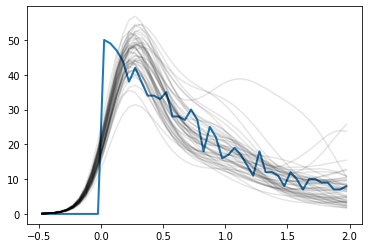

In [74]:
#plt.plot(binned_x, zscore(pred_samples['lambda_'].mean(axis=0),axis=-1), linewidth = 2)
plt.plot(binned_x, binned_counts, linewidth = 2);
plt.plot(binned_x, pred_samples['lambda_'].T, alpha = 0.1, color = 'k');

## Hierarchical Test

In [ ]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
trials = 10
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), trials)

print(f_true.shape)

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
#y = f_true + σ_true * np.random.randn(n)
y = f_true

## Plot the data and the unobserved latent function
visualize.imshow(y)
plt.figure()
plt.plot(y.T);
# fig = plt.figure(figsize=(12, 5))
# ax = fig.gca()
# ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
# ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
# ax.set_xlabel("X")
# ax.set_ylabel("The true f(x)")
# plt.legend();

In [ ]:
with pm.Model() as model:
    #alpha_ℓ = pm.HalfCauchy('alpha_ℓ',5) 
    #beta_ℓ = pm.HalfCauchy('beta_ℓ', 5) 
    #beta_η = pm.HalfCauchy('beta_η', 5) 
    
    
    #ℓ = pm.Gamma("ℓ", alpha=alpha_ℓ, beta=beta_ℓ)
    #η = pm.HalfCauchy("η", beta=beta_η)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    # Specify the covariance function.
    #cov = (η ** 2) * pm.gp.cov.Matern52(1, ℓ)
    cov = (η ** 2) * pm.gp.cov.ExpQuad(1, ls=ℓ)
    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov)

    # The scale of the white noise term can be provided,
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=20)

In [ ]:
pred_samples['f_pred'].shape

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

# plot_gp_dist(ax, pred_samples["f_pred"], X)

# # plot the data and the true latent function
# plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
# plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
# plt.figure()
plt.plot(pred_samples['f_pred'].T, "-", ms=3, alpha=0.5)
plt.figure()
visualize.imshow(pred_samples['f_pred'].T)

# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [ ]:
with pm.Model() as model:

    z = pm.Gamma('z', 1, 1, shape=trials)
    nu = pm.Gamma('nu', 1, 1)
    K = nu * pm.gp.cov.ExpQuad(trials, z)
    
    #gp = pm.gp.Marginal(cov_func=K)

    mu = pm.gp.mean.Zero()
    sigma = pm.HalfCauchy('sigma', 2.5)

    y_obs = pm.gp.GP('y_obs', mean_func=mu, cov_func=K, sigma=sigma, observed={'X': x, 'Y': y})
    #y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()